In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import re
from functools import reduce

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import countDistinct, col
import pyspark.sql.functions as F

In [2]:
sp = SparkSession.builder.appName("Summary").getOrCreate()

22/10/09 16:54:34 WARN Utils: Your hostname, J-L resolves to a loopback address: 127.0.1.1; using 172.28.113.244 instead (on interface eth0)
22/10/09 16:54:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 16:54:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/09 16:54:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
transactions = sp.read.option("inferSchema", True).parquet("../data/curated/transactions/")
transactions.show(1)

+-------+------------+------------+--------------+-----------+
|user_id|merchant_abn|dollar_value|order_datetime|   order_id|
+-------+------------+------------+--------------+-----------+
|  14935| 79417999332|      136.07|    2021-11-26|68719476736|
+-------+------------+------------+--------------+-----------+
only showing top 1 row



In [4]:
daily_revenue = transactions.groupBy("order_datetime").sum("dollar_value").withColumnRenamed("sum(dollar_value)", "Daily revenue").toPandas()
daily_revenue.head(2)

,order_datetime,Daily revenue
0,2021-12-18,5.550407e+06
1,2021-11-13,5.490926e+06


In [5]:
sns.set_style("whitegrid")
sns.set_palette("summer")

In [11]:
daily_revenue.sort_values(by="order_datetime", inplace=True)
daily_revenue["order_datetime"] = pd.to_datetime(daily_revenue["order_datetime"])
daily_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 606 entries, 598 to 99
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   order_datetime  606 non-null    datetime64[ns]
 1   Daily revenue   606 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.2 KB


In [15]:
import matplotlib.pyplot as plt

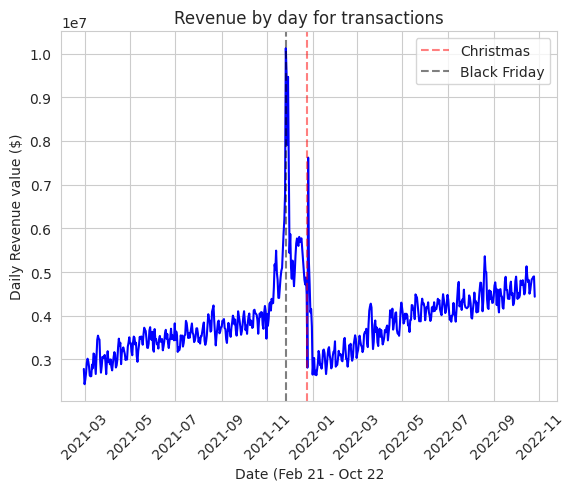

In [18]:
sns.lineplot(x="order_datetime", y="Daily revenue", data=daily_revenue, color="blue")

plt.xticks(rotation=45)

plt.axvline(pd.to_datetime("12-25-2021"), color='r', linestyle="--", label="Christmas", alpha=0.5)
plt.axvline(pd.to_datetime("11-26-2021"), color='black', linestyle="--", label="Black Friday", alpha=0.5)

plt.legend()

plt.xlabel("Date (Feb 21 - Oct 22")
plt.ylabel("Daily Revenue value ($)")
plt.title("Revenue by day for transactions")

plt.show()

In [19]:
transactions.show(1)

+-------+------------+------------+--------------+-----------+
|user_id|merchant_abn|dollar_value|order_datetime|   order_id|
+-------+------------+------------+--------------+-----------+
|  14935| 79417999332|      136.07|    2021-11-26|68719476736|
+-------+------------+------------+--------------+-----------+
only showing top 1 row



In [22]:
total_unique = transactions.groupBy("merchant_abn").agg(F.countDistinct(F.col("user_id")))
total_unique.show(2)

22/10/10 00:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:28 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/10 00:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:09:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+------------+--------------+
|merchant_abn|count(user_id)|
+------------+--------------+
| 12516851436|           210|
| 15613631617|          1714|
+------------+--------------+
only showing top 2 rows



In [24]:
total_trans = transactions.groupBy("merchant_abn").count()
total_trans.show(2)

+------------+-----+
|merchant_abn|count|
+------------+-----+
| 83412691377|14288|
| 38700038932| 7132|
+------------+-----+
only showing top 2 rows



In [31]:
interesting_plot = total_trans.join(total_unique, on="merchant_abn")
interesting_plot.show(2)
interesting_plot.count()

22/10/10 00:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:45 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/10 00:18:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:18:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+------------+-----+--------------+
|merchant_abn|count|count(user_id)|
+------------+-----+--------------+
| 12516851436|  210|           210|
| 15613631617| 1785|          1714|
+------------+-----+--------------+
only showing top 2 rows



4422

In [32]:
interesting_plot = interesting_plot.withColumnRenamed("count", "Total transactions by merchant").withColumnRenamed("count(user_id)", "Number of unique customers by merchant")
interesting_plot_pd = interesting_plot.toPandas()
interesting_plot_pd.head()

22/10/10 00:19:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/10 00:19:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/10 00:19:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


,merchant_abn,Total transactions by merchant,Number of unique customers by merchant
0,12516851436,210,210
1,15613631617,1785,1714
2,19839532017,726,714
3,24406529929,4184,3826
4,28767881738,4,4


Text(0.5, 1.0, 'Transactions vs Unique customers')

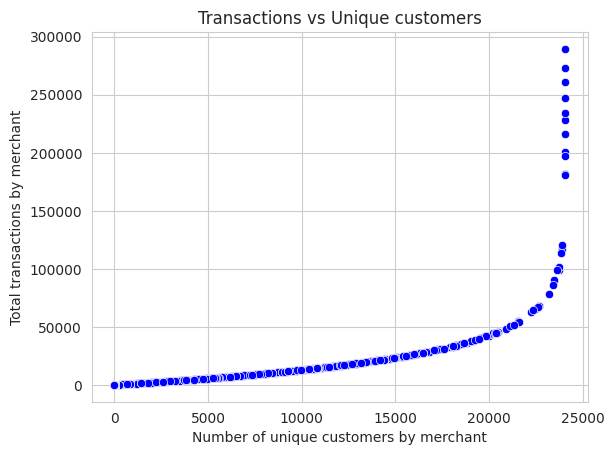

In [51]:
sns.scatterplot(x="Number of unique customers by merchant", y="Total transactions by merchant", data=interesting_plot_pd, color="blue")
plt.title("Transactions vs Unique customers")